In [2]:
from sim_util import *
from preprocess_utils import *
from utils import *
from test_suite import *

from copy import deepcopy
import pandas as pd



In [3]:
get_precision_recall_over_num_iterations(10)

   precision    recall
0   0.852941  0.966667
1   0.777778  1.000000
2   0.900000  0.931034
3   0.962963  1.000000
4   0.906250  1.000000
5   0.878788  1.000000
6   1.000000  0.923077
7   0.933333  0.965517
8   0.935484  1.000000
9   0.965517  1.000000


(0.9113054241679592, 1.0)

In [4]:
def return_false_variant_prob(ref_length, coverage, read_length, std_read_length, false_variance_density):
    """
    Return false variance with:
     -
    """
    H12, false_variant_locs = create_reference_hap(ref_length=ref_length,
                                                false_variance = false_variance_density)
    ref_H = deepcopy(H12)
    samples, st_en = generate_fragments(ref_H,
                                        read_length=read_length,
                                        std_read_length=std_read_length,
                                        coverage=coverage)


    hap_samples = deepcopy(samples)
    hap_samples = generate_miscall_error_rates_for(hap_samples)
    S1, ST_EN = cluster_fragments(hap_samples, st_en)
    er_hap_samples, sts_ens, _ = simulate_haplotypes_errors(hap_samples = S1,
                                                                            reads_st_en = ST_EN,
                                                                            false_variant_locs = false_variant_locs)
    _, __, false_vars = remove_false_variants(er_hap_samples, sts_ens, len(ref_H[0]))
    return false_variant_locs, false_vars, ref_H

def get_accuracy_measures(ref_length = 300, coverage=20, read_length=10,
                          std_read_length=2, false_variance_density=0.1,
                          threshold=None):
    false_variant_locs, prob_false_variance, ref_H = return_false_variant_prob(ref_length = ref_length,
                                                                        coverage=coverage,
                                                                        read_length=read_length,
                                                                        std_read_length=std_read_length,
                                                                         false_variance_density=false_variance_density)
    return prob_false_variance, false_variant_locs, ref_H


({172: (0, (9.77356133834173e+20, 26.0)),
  238: (0, (7.117861517989617e+20, 24.0)),
  245: (1, (9.451537048580575e+17, 24.0)),
  117: (0, (1.1791726821813334e+16, 26.0)),
  206: (0, (560552141351346.44, 23.0)),
  207: (1, (121792021663621.23, 25.0)),
  56: (0, (5980803713617144.0, 17.0)),
  25: (0, (2392008400435.0405, 28.0)),
  290: (1, (213365804833639.06, 20.0)),
  281: (1, (296207697441317.2, 18.0)),
  103: (0, (8896588134633.8, 20.0)),
  269: (0, (419789744379.3412, 22.0)),
  271: (1, (269190799291.7886, 21.0)),
  84: (0, (200202508637.21912, 20.0)),
  22: (1, (759382574.4736464, 27.0)),
  91: (1, (818057720.5116692, 20.0)),
  242: (1, (19801876.770505846, 24.0)),
  130: (1, (1475485254.6061869, 17.0)),
  154: (1, (235042006.7629384, 19.0)),
  107: (0, (6644788.114100733, 24.0)),
  111: (1, (105638236.57315782, 20.0)),
  221: (0, (37957646.25730953, 17.0)),
  126: (1, (5813532.924554119, 17.0)),
  51: (0, (132041829.43668687, 11.0)),
  6: (0, (8382131.315356962, 14.0)),
  9: (1, 

In [6]:
def get_df():
    prob_false_variance, false_variant_locs, ref_H = get_accuracy_measures()
    #print(sorted(prob_false_variance.items()))
    position = []
    predicted_genotypes = []
    ratio_prob_without_over_with = []
    coverages = []
    actual_genotypes = []
    correct = []
    for pos, data in sorted(prob_false_variance.items()):
        position.append(pos)
        predicted_genotypes.append( [data[0] , data[0]])
        actual_genotypes.append([int(ref_H[0][pos]), int(ref_H[1][pos]) ])
        if int(ref_H[0][pos]) != int(ref_H[1][pos]):
            correct.append(False)
        else:
            correct.append(True)    
        coverages.append(data[1][1])

        ratio_prob_without_over_with.append(data[1][0])
    df = pd.DataFrame(index = position)
    df['genotype'] = actual_genotypes
    df['predicted_genotype'] = predicted_genotypes
    df["coverage"] = coverages
    df["ratio_without_over_with"] = ratio_prob_without_over_with
    df["correct"] = correct
    
    print("Not Correctly predicted {}".format(set(prob_false_variance.keys()) - set(false_variant_locs)))
    print("Missed predictions {}".format( set(false_variant_locs) - set(prob_false_variance.keys())))

    return df

get_df()

Not Correctly predicted {42, 28}
Missed predictions set()


,genotype,predicted_genotype,coverage,ratio_without_over_with,correct
6,"[0, 0]","[0, 0]",16.0,2.119361e+12,True
11,"[0, 0]","[1, 1]",20.0,2.231582e+10,True
23,"[1, 1]","[1, 1]",21.0,1.926972e+00,True
24,"[0, 0]","[1, 1]",17.0,2.284766e+04,True
28,"[0, 1]","[1, 1]",15.0,1.759138e+02,False
31,"[0, 0]","[1, 1]",15.0,1.568393e+08,True
42,"[0, 1]","[1, 1]",24.0,5.633038e+02,False
44,"[0, 0]","[0, 0]",24.0,7.130245e+15,True
46,"[0, 0]","[0, 0]",20.0,4.701563e+11,True
65,"[1, 1]","[0, 0]",15.0,1.464170e+06,True


/home/ruchirgarg5/content/HAPCUT_preprocessing


In [73]:
def run_multiple(it = 10):
    for i in range(it):
        df = get_df()
        df.to_excel(f"data/xlsxs/out_put{i}.xlsx")
run_multiple()

array([[0.00630957, 0.80309362],
       [0.00794328, 0.03940775],
       [0.01      , 0.02876161],
       [0.01258925, 0.02323998],
       [0.01584893, 0.01573284],
       [0.01995262, 0.01299094],
       [0.02511886, 0.00907664],
       [0.03162278, 0.00754496],
       [0.03981072, 0.00629692],
       [0.05011872, 0.00637256],
       [0.06309573, 0.00642929],
       [0.07943282, 0.00612673],
       [0.1       , 0.00894427],
       [0.12589254, 0.00803661],
       [0.15848932, 0.00794206],
       [0.19952623, 0.01000321]])

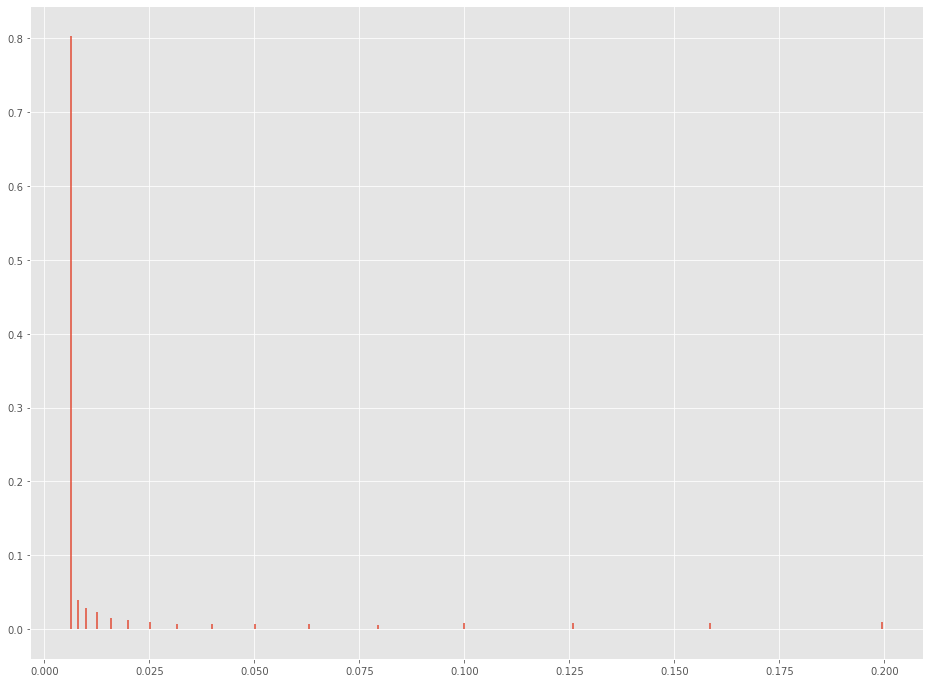

In [17]:
fragments_path='data/fragments/chr20_1-500K/fragments.txt'
longshot_vcf_path='data/fragments/chr20_1-500K/2.0.realigned_genotypes.vcf'
get_error_freq(fragments_path, longshot_vcf_path, plot=True)

In [27]:
import warnings
import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels.api as sm
from scipy.stats._continuous_distns import _distn_names
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')

# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Best holders
    best_distributions = []

    # Estimate distribution parameters from data
    for ii, distribution in enumerate([d for d in _distn_names if not d in ['levy_stable', 'studentized_range']]):

        print("{:>3} / {:<3}: {}".format( ii+1, len(_distn_names), distribution ))

        distribution = getattr(st, distribution)

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')
                
                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]
                
                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))
                
                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                best_distributions.append((distribution, params, sse))
        
        except Exception:
            pass

    
    return sorted(best_distributions, key=lambda x:x[2])

def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf





In [31]:
fragments_path='data/fragments/chr20_1-500K/fragments.txt'
longshot_vcf_path='data/fragments/chr20_1-500K/2.0.realigned_genotypes.vcf'
_, fragments, quals = read_fragments(fragments_path)
callset = allel.read_vcf(longshot_vcf_path)
filter = callset["variants/FILTER_PASS"]
fragments_filter, quals_filter = fragments[:, filter], quals[:, filter]

reads, st_en = cluster_fragments(*compress_fragments(fragments_filter, quals_filter))
quals_array = [ np.array([x for y, x in zip(r[0],r[1]) if (y == 0 or y  == 1) ]) for r in reads]
quals1 = pd.Series(np.concatenate(quals_array))
data = quals1[:1000]

  1 / 104: ksone
  2 / 104: kstwo
  3 / 104: kstwobign
  4 / 104: norm
  5 / 104: alpha
  6 / 104: anglit
  7 / 104: arcsine
  8 / 104: beta
  9 / 104: betaprime
 10 / 104: bradford
 11 / 104: burr
 12 / 104: burr12
 13 / 104: fisk
 14 / 104: cauchy
 15 / 104: chi
 16 / 104: chi2
 17 / 104: cosine
 18 / 104: dgamma
 19 / 104: dweibull
 20 / 104: expon
 21 / 104: exponnorm
 22 / 104: exponweib
 23 / 104: exponpow
 24 / 104: fatiguelife
 25 / 104: foldcauchy
 26 / 104: f
 27 / 104: foldnorm
 28 / 104: weibull_min
 29 / 104: weibull_max
 30 / 104: genlogistic
 31 / 104: genpareto
 32 / 104: genexpon
 33 / 104: genextreme
 34 / 104: gamma
 35 / 104: erlang
 36 / 104: gengamma
 37 / 104: genhalflogistic
 38 / 104: genhyperbolic
 39 / 104: gompertz
 40 / 104: gumbel_r
 41 / 104: gumbel_l
 42 / 104: halfcauchy
 43 / 104: halflogistic
 44 / 104: halfnorm
 45 / 104: hypsecant
 46 / 104: gausshyper
 47 / 104: invgamma
 48 / 104: invgauss
 49 / 104: geninvgauss
 50 / 104: norminvgauss
 51 / 104: 

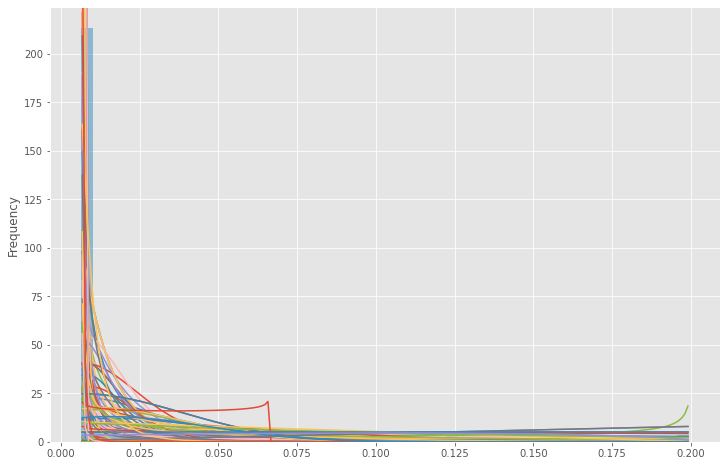

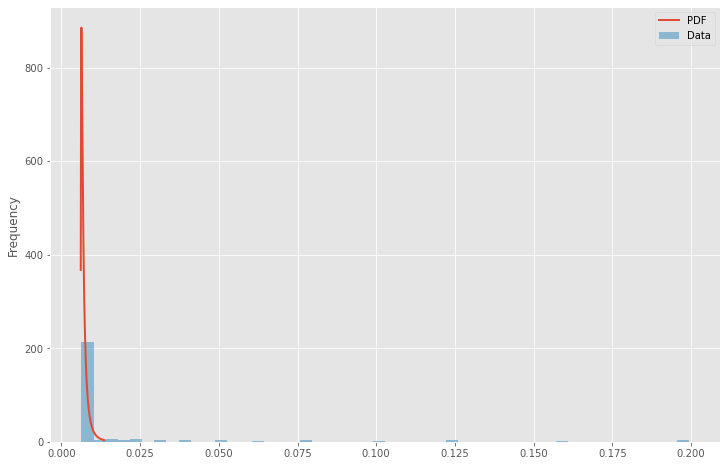

In [32]:
# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=50, density=True, alpha=0.5, color=list(matplotlib.rcParams['axes.prop_cycle'])[1]['color'])

# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_distibutions = best_fit_distribution(data, 200, ax)
best_dist = best_distibutions[0]

# Update plots
ax.set_ylim(dataYLim)

# Make PDF with best params 
pdf = make_pdf(best_dist[0], best_dist[1])

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist[0].shapes + ', loc, scale').split(', ') if best_dist[0].shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_dist[1])])
dist_str = '{}({})'.format(best_dist[0].name, param_str)

Notes: We want to incorporate sequencing errors in the fragments f1 and f2 and get the confidence whether f1 and f2 belong from the same haplotype. Use some probablity to guess whether f1 and f2 belong to the same haplotype. 

Now once we have a probablity that f1 and f2 belong to the same haplotype, we want to check whether a variant is a false variant.

What is a false variant ? 
False variant is a location where the alleles are homozygous but the sequencing 
assumes / wrongly interprets the site as heterozygous. 
Hitherto, in the fragments (for these false variants) there would be a substantial amount of fragments where this site has the same allele say 0 for 
both fragments coming from both H1 and H2 (as it is not really a variant hence same allele is observed irrespective sample from H1 or H2 (0, 0) in the given position).

However for sequencing errors the errors are randomly distributed among different variants for different fragments.

Problem statement, we want to identify these false variant locations for the 
sequenced data, as these become difficult to handle while performing Hap assembly.

When we have a good coverage for a particular false variant, 
if we have fragment f1 which belongs to H1 and a fragment f2 which belongs to H2, the value for the variants are complement of each other except for the false variant. 

Now we dont know whether the fragment belongs to either H1 or H2, 